## Linear Regression for Predicting Google Stock Prices

In [58]:
import pandas as pd
import math, datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')

In [59]:
import quandl
quandl.ApiConfig.api_key="bsZzMiC7v9JnsD46JhM3"
df = quandl.get('WIKI/GOOGL')

## Data Exploration

In [60]:
df.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2017-11-01,1036.32,1047.86,1034.00,1042.60,2105729.0,0.0,1.0,1036.32,1047.86,1034.00,1042.60,2105729.0
2017-11-02,1039.99,1045.52,1028.66,1042.97,1233333.0,0.0,1.0,1039.99,1045.52,1028.66,1042.97,1233333.0
2017-11-03,1042.75,1050.66,1037.65,1049.99,1370874.0,0.0,1.0,1042.75,1050.66,1037.65,1049.99,1370874.0
2017-11-06,1049.10,1052.59,1042.00,1042.68,897897.0,0.0,1.0,1049.10,1052.59,1042.00,1042.68,897897.0
2017-11-07,1049.65,1053.41,1043.00,1052.39,1254965.0,0.0,1.0,1049.65,1053.41,1043.00,1052.39,1254965.0


## Data Cleaning

In [61]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100

In [62]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change','Adj. Volume']]
df.tail()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2017-11-01,1042.60,0.504508,0.605990,2105729.0
2017-11-02,1042.97,0.244494,0.286541,1233333.0
2017-11-03,1049.99,0.063810,0.694318,1370874.0
2017-11-06,1042.68,0.950435,-0.611953,897897.0
2017-11-07,1052.39,0.096922,0.261039,1254965.0


In [63]:
forecast_col='Adj. Close' 

In [64]:
df.fillna(-99999, inplace=True)

In [65]:
forecast_out= int(math.ceil(0.01*len(df))) # 1% of the DataFrame
forecast_out

34

In [66]:
df['label']=df[forecast_col].shift(-forecast_out)
# this way the label column for each row will be...
# ... the adjusted price of 100 days into the future

In [67]:
df.head(10)

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0,69.639972
2004-08-20,54.322689,0.710922,7.227007,22834300.0,69.078238
2004-08-23,54.869377,3.729433,-1.227880,18256100.0,67.839414
2004-08-24,52.597363,6.417469,-5.726357,15247300.0,68.912727
2004-08-25,53.164113,1.886792,1.183658,9188600.0,70.668146
2004-08-26,54.122070,0.037068,2.820391,7094800.0,71.219849
2004-08-27,53.239345,2.326896,-1.803885,6211700.0,72.278116
2004-08-30,51.162935,3.411430,-3.106003,5196700.0,74.810934
2004-08-31,51.343492,1.308977,0.048866,4917800.0,74.199045


## Building the Model

### Creating features and Labels

In [68]:
X = np.array(df.drop(['label'],1)) #features

### Preprocessing Data
`sklearn.preprocessing` package provides several common utility functions and transformer classes to change raw feature vectors into a representation that is more suitable for the downstream estimators.

*Standardization of datasets* is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: *Gaussian with zero mean and unit variance.*

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.

In [69]:
from sklearn import preprocessing

In [70]:
X = preprocessing.scale(X) 
# Standardize a dataset along any axis.
# Center to the mean and component wise scale to unit variance.
X

array([[-1.45021271,  2.3336877 ,  0.23130001,  4.41876971],
       [-1.43312883, -0.31359081,  4.81410445,  1.78898324],
       [-1.43079386,  2.34856641, -0.79975707,  1.237329  ],
       ..., 
       [ 2.81949926, -0.88430747,  0.47654065, -0.79727119],
       [ 2.78827727, -0.10235373, -0.39079492, -0.85426298],
       [ 2.82974998, -0.85510445,  0.18885313, -0.81123775]])

In [71]:
X, X_lately = X[:-forecast_out], X[-forecast_out:]
df.dropna(inplace=True)

In [72]:
y = np.array(df['label']) # label
y

array([   69.63997192,    69.0782379 ,    67.83941377, ...,  1049.99      ,
        1042.68      ,  1052.39      ])

### Splitting the dataset
While experimenting with any learning algorithm, it is important not to test the prediction of an estimator on the data used to fit the estimator as this would not be evaluating the performance of the estimator on new data. This is why datasets are often split into train and test data.
#### A random permutation, to split the data randomly
```python
np.random.seed(42)
indices = np.random.permutation(len(X))
X_train = X[indices[:-20]]
y_train = y[indices[:-20]]
X_test = X[indices[-20:]]
y_test = y[indices[-20:]]
```
#### But we will use the `train_test_split` function from `sklearn.model_selection`

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

#### Importing the model

In [75]:
from sklearn.linear_model import LinearRegression

#### Create and Fit a Linear Regression Model

In [76]:
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train) # fit is synonymous with train

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

## Predictions

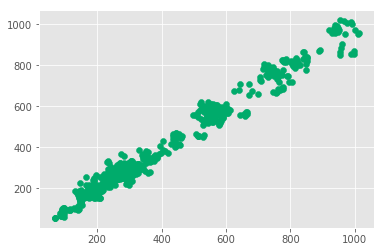

In [77]:
y_pred = clf.predict(X_test)
plt.scatter(y_test,y_pred,color='#00ab6b')

## Evaluation

In [78]:
accuracy= clf.score(X_test,y_test) # score is synonymous with test
accuracy

0.97592388188007251

### Let's Forecast some data

In [80]:
df['Forecast'] = np.nan
last_date = df.iloc[-1].name # Timestamp('2017-09-08 00:00:00')
last_unix = last_date.timestamp() # 1504809000.0
one_day = 86400
next_unix = last_unix + one_day # 1504895400.0
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix) # datetime.datetime(2017, 9, 9, 0, 0)
    next_unix+=one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
    
fig,ax=plt.subplots(figsize=(14,8))
ax.set(ylim=[800,1100],xlabel='Date',ylabel='Price')
df=df.tail(200)
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=2)

NameError: name 'forecast_set' is not defined

### Let's use another algorithm

In [81]:
from sklearn import svm

0.64467482450361402

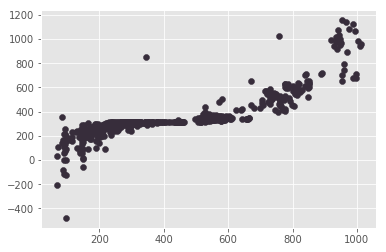

In [82]:
clf2 = svm.SVR( kernel='poly' ) # support vector regression
clf2.fit( X_train, y_train )
y_pred2 = clf2.predict( X_test )
plt.scatter( y_test,y_pred2,color='#372d3b' )
clf2.score( X_test,y_test )